In [27]:
import json
from lib.Reaction_Library_Mother import *

from IPython.display import Image, SVG, display
from rdkit import Chem
from rdkit.Chem import AllChem,Draw,Descriptors
from rdkit.Chem.Draw import IPythonConsole, ReactionToImage

import copy
import pandas as pd
import re
import matplotlib.pyplot as plt
from random import randint

import lib.Reaction_Library as RL 

import numpy as np
import os
import seaborn as sns

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
df_ox = pd.read_csv('data_for_Ben/21C_G2G3_oxidations.csv')
df_red = pd.read_csv('data_for_Ben/21C_G2G3_reductions.csv')

In [7]:
print df_red.query('category==2').shape
print df_red.query('category==3').shape

(4299, 2)
(4299, 2)


In [8]:
print df_ox.query('category==2').shape
print df_ox.query('category==3').shape

(257604, 2)
(48796, 2)


In [ ]:
df_exp = pd.read_csv('')

# General Functions

In [28]:
def add_names(x, names_dict):
    try:
        comp_name = names_dict[x.KEGG_IDs]
    except:
        comp_name = 'NO_NAME'
    return comp_name

def clean_up_mols(df):
    df_no_SFClBr = df[ ~(df.smiles.str.contains('S')) & ~(df.smiles.str.contains('F')) 
                   & ~(df.smiles.str.contains('Cl')) & ~(df.smiles.str.contains('Br'))
                     & ~(df.smiles.str.contains('I')) & ~(df.smiles.str.contains('Zn'))]
    return df_no_SFClBr

# Tests

## Generate full 2-C redox network: 

In [5]:
seed_metabolite = 'OC(=O)C(=O)C(=O)C(=O)C(O)=O'
Master_Sub_List = []
rxn_list, Master_Sub_List = reduce_metabolite(seed_metabolite, Master_Sub_List)

In [6]:
print 'Number of reactions: ', len(rxn_list)

Number of reactions:  30


Sort reactions: 

In [ ]:
rxn_list.sort(key = len, reverse = True)

In [ ]:
df_rxn = pd.DataFrame(columns=['rxn', 'subs', 'prods'])
df_rxn['rxn'] = rxn_list
df_rxn['subs'] = [rxn.split('>>')[0] for rxn in rxn_list]
df_rxn['prods'] = [rxn.split('>>')[1] for rxn in rxn_list]
# Categorize reactions: 
df_rxn['category'] = df_rxn.apply(RL.categorize_rxn, 1)
# df_rxn.to_csv('rxn_networks/rxns_2C.csv', sep = '\t', index = False)

In [ ]:
df_temp = df_rxn[df_rxn.category == 4]
for i in df_temp.index: 
    rxn = df_temp.loc[i, 'rxn']
    print 'Category:', df_temp.loc[i, 'category']
    display(AllChem.ReactionFromSmarts(rxn))

Get unique molecules: 

In [ ]:
subs = [rxn.split('>>')[0] for rxn in rxn_list]
prods = [rxn.split('>>')[1] for rxn in rxn_list]
mols_unique = list(set(subs + prods))
print "Number of Molecules: ", len(mols_unique)
print mols_unique

Can you determined the oxidation state of carbon atom in each molecule? 

In [ ]:
def get_num_O_bond_list(mol_temp):
    num_O_bond_list = []
    for atom in mol_temp.GetAtoms():
        if atom.GetAtomicNum() == 6:
            num_O_bonds = 0
            C_Idx = atom.GetIdx()
            O_neighbors = [a for a in atom.GetNeighbors() if a.GetSymbol() == 'O']
            for O in O_neighbors: 
                O_Idx = O.GetIdx()
                bond_type = str(mol_temp.GetBondBetweenAtoms(C_Idx, O_Idx).GetBondType())
                if bond_type == 'SINGLE':
                    num_O_bonds += 1
                elif bond_type == 'DOUBLE':
                    num_O_bonds += 2
            num_O_bond_list.append(num_O_bonds)
    return num_O_bond_list

In [ ]:
def ox_num(x):
    return np.sum(x.num_Ox)

def ox_to_color(x):
    ox_col_dict = {3:'r',2:'g',1:'b',0:'gray'}
    color_list = [ox_col_dict[ox] for ox in x.num_Ox]
    return '-'.join(color_list)
    

In [ ]:
num_O_bond_ALL = []
for mol_smi in mols_unique:
    mol_temp = Chem.MolFromSmiles(mol_smi)
    num_O_bond_list = get_num_O_bond_list(mol_temp)
    # How do we store this? 
    num_O_bond_ALL.append(num_O_bond_list)

In [ ]:
df_num_O = pd.DataFrame(columns=['smiles', 'num_Ox', 'Ox', 'color'])
df_num_O['smiles'] = mols_unique
df_num_O['num_Ox'] = num_O_bond_ALL
df_num_O['Ox'] = df_num_O.apply(ox_num, 1)
df_num_O['color'] = df_num_O.apply(ox_to_color,1)

In [ ]:
df_num_O['Ox'].unique()

In [ ]:
df_temp = df_num_O[df_num_O.Ox == 4]
for i in df_temp.index:
    print df_temp.loc[i, 'num_Ox']
    mol_smi = df_temp.loc[i, 'smiles']
    print mol_smi
    display(Chem.MolFromSmiles(mol_smi))

In [ ]:
df_num_O.to_csv('rxn_networks/mols_6C.csv', sep = '\t', index = False)

## Editing reaction files to fit the parameter.txt file format for quantum chemistry calculations:

In [ ]:
def to_param_format(x):
    return ' = '.join(x.rxn.split('>>'))

In [ ]:
df_rxn_all = pd.DataFrame()
for n in [5]:
    df_rxn = pd.read_csv('rxn_networks/rxns_'+str(n)+'C.csv', sep = '\t')
    df_rxn_all = pd.concat([df_rxn_all, df_rxn], 0)

In [ ]:
df_rxn_all['rxn_param'] = df_rxn_all.apply(to_param_format, 1)
df_rxn_all.reset_index(inplace=True, drop=True)

In [ ]:
df_rxn_all[['rxn_param', 'category']].to_csv('rxn_networks/rxns_5.csv', sep = '\t', index = False)

## Editing molecule dataframes so that we have a name (like a KEGG ID) for each redox metabolite.

In [ ]:
df_all_mols = pd.DataFrame()
for n in [2,3,4,5,6]:
    df_num_O = pd.read_csv('rxn_networks/mols_'+str(n)+'C.csv', sep = '\t')
    df_all_mols = pd.concat([df_all_mols, df_num_O], 0)

In [ ]:
id_list = range(len(df_all_mols))
redox_id = ['R'+str(n).rjust(5,'0') for n in id_list]

In [ ]:
df_all_mols['redox_id'] = redox_id
df_all_mols.reset_index(inplace=True, drop=True)

In [ ]:
df_all_mols[['redox_id', 'smiles']].to_csv('rxn_networks/mols_all.csv', sep = '\t', index = False)

In [ ]:
redox_id_dict = {}
for i in df_all_mols.index:
    key = df_all_mols.loc[i, 'redox_id']
    value = df_all_mols.loc[i, 'smiles']
    redox_id_dict[key] = value

Add water and hydrogen molecule:

In [ ]:
redox_id_dict['C00001'] = 'O'
redox_id_dict['C00282'] = '[H][H]'

In [ ]:
import json
import os
path_temp = '/Users/ajinich/Dropbox (Aspuru-Guzik Lab)/FreeEnergiesHA/mamacori/input/redox_mols'
with open(os.path.join(path_temp, 'redox_dict.json') , 'w') as fout:
    json.dump(redox_id_dict, fout)

In [ ]:
with open(os.path.join(path_temp, 'redox_dict.json') , 'r') as fin:
    dict_temp = json.load(fin)
dict_temp

## Convert reaction list to R-ID format: 

In [ ]:
df_rxn = pd.read_csv('rxn_networks/rxns_5.csv', sep = '\t')
df_rxn.head()

In [ ]:
def rxn_to_ID(x, df_all_mols):
    subs = df_all_mols[df_all_mols.smiles == x.rxn_param.split(' = ')[0]].redox_id.values[0]
    subs = ' + '.join([subs, 'C00282'])
    prods = df_all_mols[df_all_mols.smiles == x.rxn_param.split(' = ')[1]].redox_id.values[0]
    if x.category == 1 or x.category == 4:
        prods = ' + '.join([prods, 'C00001'])
    return ' = '.join([subs, prods])

In [ ]:
df_all_mols = pd.read_csv('rxn_networks/mols_all.csv', sep = '\t')

In [ ]:
df_rxn['rxn_RID'] = df_rxn.apply(rxn_to_ID, 1, args=[df_all_mols])


In [ ]:
df_rxn.head()

In [ ]:
df_rxn.to_csv('rxn_networks/rxns_5.csv', sep = '\t', index = False)

In [ ]:
param_path = '~/Dropbox (Aspuru-Guzik Lab)/FreeEnergiesHA/mamacori/data/precalc/rxns_5.csv'
df_rxn['rxn_RID'].to_csv(param_path, sep = '\t', index = False)

__________________
__________________
__________________
__________________
__________________
__________________
__________________
__________________
__________________
__________________


# PART 2: Iterative reduction / oxidation of n-carbon metabolites in the KEGG database. 

Trying to load Josh's KEGG database of names. 

In [31]:
df_names_josh = pd.read_csv('data/KEGG_names.csv')
names_dict_josh = dict(zip(df_names_josh.KEGG_ID,df_names_josh.name))

Load .json file of Kegg smiles in canonical format:

In [32]:
# KEGG smiles in canonical form: 
kegg_smiles = 'data/Kegg_Canonical_Final.json'

# Read json as series and convert to dataframe
ser_kegg = pd.read_json(kegg_smiles, typ='series')
df_kegg = ser_kegg.to_frame('smiles')
df_kegg['KEGG_IDs'] = df_kegg.index
df_kegg.reset_index(level=[], inplace=True)
df_kegg = df_kegg[['KEGG_IDs', 'smiles']]

# Get number of carbons
df_kegg['numC'] = df_kegg.apply(RL.count_carbons, 1)
# df_kegg = df_kegg[df_kegg.numC>0]

# remove generic compounds 
df_kegg = df_kegg[~df_kegg.smiles.str.contains('\*')]
df_kegg = df_kegg[~df_kegg.smiles.str.contains('\#')]
df_kegg = df_kegg[~df_kegg.smiles.str.contains('\.')]

# Add names: 
df_kegg['name'] = df_kegg.apply(add_names, 1, args=[names_dict_josh])

df_kegg.sort_values('numC', inplace=True)
kegg_smiles = df_kegg.smiles.values

In [33]:
df_kegg = clean_up_mols(df_kegg)
df_kegg.reset_index(inplace=True, drop=True)

In [24]:
save_flag = False
if save_flag:
    df_kegg.to_csv('KID_smiles_numC_name_forH20.csv', index=False)

Take a peek at some random KEGG metabolites: 

In [10]:
df_kegg.columns

Index([u'KEGG_IDs', u'smiles', u'numC', u'name'], dtype='object')

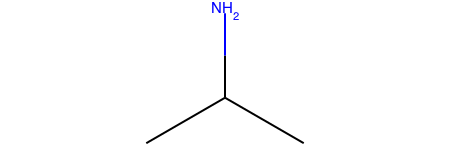

In [11]:
sm_temp = df_kegg[df_kegg.KEGG_IDs=='C00186'].smiles.values[0]
sm_temp = 'CC(-N)C'
AllChem.MolFromSmiles(sm_temp)

CC(=O)[C@@]12OC(C)(c3ccco3)O[C@@H]1C[C@H]1[C@@H]3CCC4=CC(=O)CC[C@]4(C)[C@H]3CC[C@@]12C
16alpha,17-Dihydroxypregn-4-ene-3,20-dione cyclic acetal with 2-furyl methyl ketone


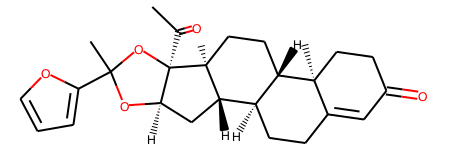

In [35]:
int_temp = randint(0, df_kegg.shape[0])
print(df_kegg.loc[int_temp, 'smiles'])
print(df_kegg.loc[int_temp, 'name'])
AllChem.MolFromSmiles(df_kegg.loc[int_temp, 'smiles'])

In [87]:
df_kegg[df_kegg.numC == 135]

,KEGG_IDs,smiles,numC,name
9569,C11827,CC(=O)N[C@H]1[C@H](O[C@@H]2[C@@H](CO)O[C@@H](O...,135,[GlcNAc-(1->4)-Mur2Ac(oyl-L-Ala-g-D-Glu-A2pm-D...


# This is a great insight.  Target this as a tool for pharmaceutical compounds!

## Take a peek at molecules of n-carbons:

In [36]:
df_nC = df_kegg[df_kegg.numC == 20]

Tetracenomycin F2--(C12366)


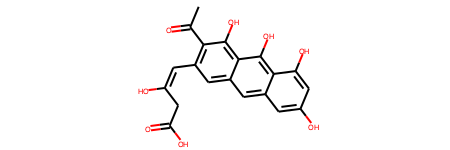

(-)-Ormosanine--(C10777)


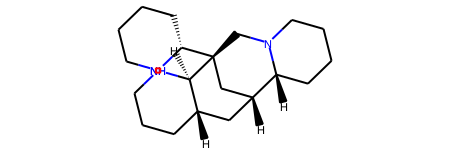

trans,trans,cis-Geranylgeranyl diphosphate--(C11356)


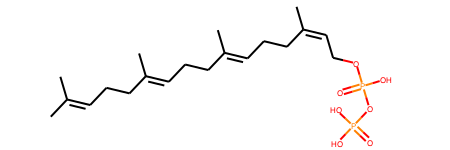

In [38]:
df_sample = df_nC.sample(3)
for index in df_sample.index:
    smi = df_sample.loc[index, 'smiles']
    KEGG_ID = df_sample.loc[index, 'KEGG_IDs']
    name = df_sample.loc[index, 'name']
    print(name + '--('+KEGG_ID+')')
    display(AllChem.MolFromSmiles(smi))

## Plot number of compounds as a function of number of carbon atoms to guide the cutoff decision: 

In [39]:
numC_dict = df_kegg.numC.value_counts().to_dict()
numC_dict[6]

602

In [ ]:
plt.figure(figsize = (8, 6))
plt.plot(numC_dict.keys(), numC_dict.values(), '-o', ms = 10)
plt.xlim(0, 30)
plt.xlabel('Number Carbons', fontsize = 24)
plt.ylabel('Metabolite Count', fontsize = 24)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)

### Cut off at certain number of carbons

In [40]:
df_cutoff = df_kegg[df_kegg.numC <= 21]
smiles_cutoff = df_cutoff.smiles.values

In [42]:
df_cutoff.shape

(7173, 4)

In [ ]:
df_cutoff.head()

# Run the reduction and oxidation functions on the KEGG database

### Step 1: Run in the direction of reduction

In [182]:
# Empty list of all reactions. 
rxn_list = []
Master_Sub_List = []
counter = 0

# for each KEGG metabolite
for metabolite in smiles_cutoff:
    
    # Run reduction function on a single metabolite
    rxn_list_temp, Master_Sub_List = reduce_metabolite(metabolite, Master_Sub_List)    
    
    # If there are some reactions, store in reaction list
    if len(rxn_list_temp) > 0:
        rxn_list += rxn_list_temp
        # Make Unique (is this necessary?)
        rxn_list = list(set(rxn_list)) 
    
    # Update Master_Sub_List
    new_subs_list = [rxn.split('>>')[0] for rxn in rxn_list_temp]
    Master_Sub_List += new_subs_list
    Master_Sub_List = list(set(Master_Sub_List))
    
    # Update counter variable and print every 100 steps. 
    counter += 1
    if counter%100 == 0:
        print counter

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100


In [183]:
rxn_list = list(set(rxn_list))
rxn_list.sort(key = len)
print len(rxn_list)

8598


In [184]:
df_reduction_cutoff = pd.DataFrame()
df_reduction_cutoff['rxn'] = rxn_list

CCCc1cc(O)cc2C(=O)c3cc(O)cc(O)c3C(O)c12>>CCCc1cc(O)cc2c1C(O)c1c(O)cc(O)cc1C2O


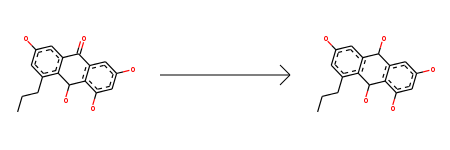

O=C1CCC(C(=O)O)c2ccccc21>>NC1CCC(C(=O)O)c2ccccc21


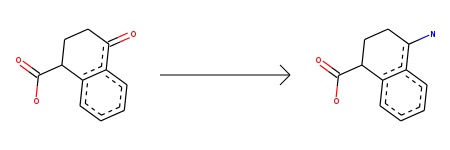

CCC(=O)CC(O)c1c(cc2C(=O)c3cccc(O)c3C(=O)c2c1O)CC(=O)O>>CCC(=O)CC(O)c1c(cc2C(=O)c3cccc(O)c3C(N)c2c1O)CC(=O)O


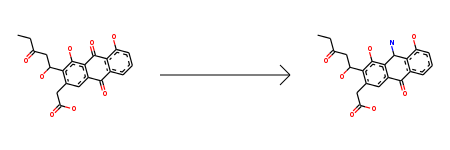

CC1=CC(=O)c2c(O)cccc2C1=O>>CC1=CC(O)c2c(O)cccc2C1=O


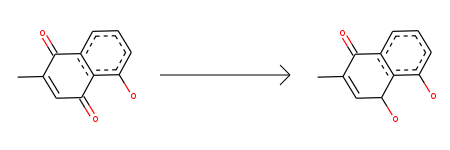

COc1cc(O)c(NC(=O)C(C)=O)c(C(=O)O)c1>>COc1cc(O)c(NC(=O)C(C)O)c(c1)C(=O)O


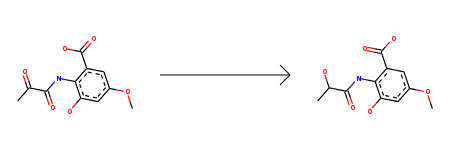

In [212]:
df_rand = df_reduction_cutoff.sample(5)
for i in df_rand.index:
    smiles_str = df_rand.loc[i, 'rxn']
    print smiles_str
    display(AllChem.ReactionFromSmarts(str(smiles_str)))

In [187]:
df_reduction_cutoff['category'] = df_reduction_cutoff.apply(RL.categorize_rxn, 1)

In [188]:
df_reduction_cutoff.to_csv('data_for_Ben/21C_G2G3_reductions.csv', index = False)

### Oxidation

In [189]:
# Empty list of all reactions. 
rxn_list_ox = []
Master_Sub_List = []
counter = 0
# for each KEGG metabolite
for metabolite in smiles_cutoff:
    # Run reduction function on a single metabolite
    rxn_list_temp, Master_Sub_List = oxidize_metabolite(metabolite, Master_Sub_List)
    # print 'Current rxn_list_temp', rxn_list_temp
    
    # If there are some reactions, store in reaction list
    if len(rxn_list_temp) > 0:
        rxn_list_ox += rxn_list_temp
        # Make Unique (necessary ?)
        rxn_list_ox = list(set(rxn_list_ox)) 
#     Update reaction file:
#         update_rxn_file(rxn_network_file, rxn_list_ox)
    
    # Update Master_Sub_List
    new_subs_list = [rxn.split('>>')[0] for rxn in rxn_list_temp]
    Master_Sub_List += new_subs_list
    Master_Sub_List = list(set(Master_Sub_List))
    # print 'Updated MasterSubList', Master_Sub_List, '\n'
    
    # Update counter variable and print every 100 steps. 
    counter += 1
    if counter%100 == 0:
        print counter

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100


In [190]:
rxn_list_ox = list(set(rxn_list_ox))
rxn_list_ox.sort(key = len)

In [191]:
len(rxn_list_ox)

306400

In [192]:
df_oxidation_cutoff = pd.DataFrame()
df_oxidation_cutoff['rxn'] = rxn_list_ox

In [ ]:
df_rand = df_oxidation_cutoff.sample(10)
for i in df_rand.index:
    smiles_str = df_rand.loc[i, 'rxn']
    print smiles_str
    display(AllChem.ReactionFromSmarts(str(smiles_str)))

Missing: Write oxidations to file: 

In [196]:
df_oxidation_cutoff['category'] = df_oxidation_cutoff.apply(RL.categorize_rxn_ox, 1)

In [197]:
df_oxidation_cutoff.to_csv('data_for_Ben/21C_G2G3_oxidations.csv', index = False)

## Combine the oxidations and the reductions into a single file:

Reverse oxidative reactions:

In [198]:
def reverse_reaction(row):
    sub = row.rxn.split('>>')[0]
    prod = row.rxn.split('>>')[1]
    
    new_rxn = prod + '>>' + sub
    
    return new_rxn

In [199]:
df_oxidation_cutoff['rxn'] = df_oxidation_cutoff.apply(reverse_reaction, 1)

In [200]:
path = pd.concat([df_reduction_cutoff, df_oxidation_cutoff], 0)
df_redox.reset_index(inplace=True, drop=True)

In [201]:
df_redox.shape

(314998, 2)

Remove duplicated reactions:

In [202]:
df_redox.drop_duplicates('rxn', inplace=True)
df_redox.shape

(314794, 2)

In [203]:
df_redox.rename(columns={'rxn':'rxn_smiles'}, inplace=True)
df_redox.head(2)

,rxn_smiles,category
0,CC=O>>CCO,2
1,CC=O>>CCN,3


Create dataframe

In [204]:
df_redox['subs_smiles'] = [rxn.split('>>')[0] for rxn in df_redox.rxn_smiles.values]
df_redox['prods_smiles'] = [rxn.split('>>')[1] for rxn in df_redox.rxn_smiles.values]

NC1C(=O)C(=O)C(C=O)OC1OC1C(=O)CC(NC(=O)C(O)CC=O)C(O)C1OC1OC(C=O)C(O)C1=O>>NC1CC(NC(=O)C(O)CC=O)C(O)C(OC2OC(C=O)C(O)C2=O)C1OC1OC(C=O)C(=O)C(=O)C1N
3


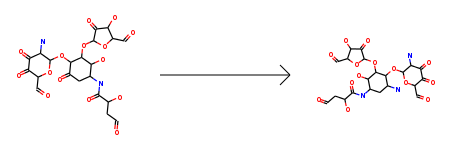

CNC1C(OC2OC(C=O)C(N)C(O)C2=O)OC2C(=O)C(=O)C(OC3C(=O)CC(N)C(O)C3O)OC2C1O>>CNC1C(OC2OC(C=O)C(N)C(O)C2=O)OC2C(=O)C(N)C(OC3C(=O)CC(N)C(O)C3O)OC2C1O
3


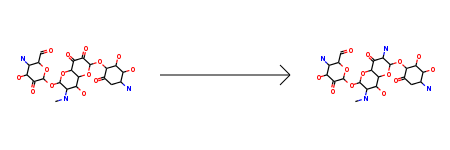

O=C1C(=C(O)C(O)c2cc(O)cc(O)c21)c1c(O)cc(O)c2c1C(=O)C(O)=CC2O>>NC1C(=C(O)C(O)c2cc(O)cc(O)c21)c1c(O)cc(O)c2c1C(=O)C(O)=CC2O
3


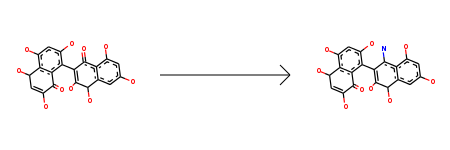

NCC1OC(OC2C(=O)C(OC3OC(C=O)C(=O)C(=O)C3O)C(=O)CC2N)C(=O)C(OP(=O)(O)O)C1O>>NCC1OC(OC2C(=O)C(OC3OC(C=O)C(=O)C(N)C3O)C(=O)CC2N)C(=O)C(OP(=O)(O)O)C1O
3


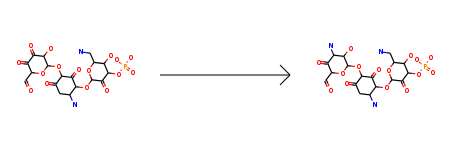

CNC1C(=O)C2OC(OC3C(=O)CC(=O)C(O)C3O)C(=O)C(O)C2OC1OC1OC(CO)C(N)C(=O)C1=O>>CNC1C(=O)C2OC(OC3C(=O)CC(=O)C(O)C3O)C(N)C(O)C2OC1OC1OC(CO)C(N)C(=O)C1=O
3


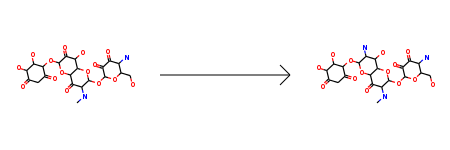

In [213]:
df_rand = df_redox[df_redox.category==3].sample(5)
for i in df_rand.index:
    smiles_str = df_rand.loc[i, 'rxn_smiles']
    category = df_rand.loc[i, 'category']
    print str(smiles_str)
    print category
    display(AllChem.ReactionFromSmarts(str(smiles_str)))

In [ ]:
# df_redox.to_csv('data_for_Ben/6C_G2G3_redox.csv', index=False)

# Get unique molecules, generate compound ID's, etc. 

Get unique set of molecules: 

In [205]:
subs = [rxn.split('>>')[0] for rxn in df_redox.rxn_smiles.values]
prods = [rxn.split('>>')[1] for rxn in df_redox.rxn_smiles.values]
comps = list(set(subs+prods))
df_mols = pd.DataFrame(columns=['smiles'])
df_mols['smiles'] = comps

In [207]:
df_mols['numC'] = df_mols.apply(RL.count_carbons, 1)

df_mols.sort_values('numC', inplace=True)
df_mols.reset_index(inplace=True, drop=True)

Add made-up KEGG IDs:

In [208]:
BA_IDs = ['Z'+str(int(i)).zfill(5) for i in np.arange(df_mols.shape[0])]
df_mols['BA_ID'] = BA_IDs

In [209]:
df_mols.head()

,smiles,numC,BA_ID
0,O=CCOP(=O)(O)O,2,Z00000
1,O=CCO,2,Z00001
2,NCCP(=O)(O)O,2,Z00002
3,NCC=O,2,Z00003
4,CCN,2,Z00004


# Add BA_ID info to reaction dataframe:

In [210]:
def add_BA_IDs(row, df_mols):
    sub_smiles = row.subs_smiles
    prod_smiles = row.prods_smiles
    sub_ID = df_mols[df_mols.smiles == sub_smiles]['BA_ID'].values[0]
    prod_ID = df_mols[df_mols.smiles == prod_smiles]['BA_ID'].values[0]
    return ' = '.join([sub_ID, prod_ID])

In [211]:
df_redox['rxn_ID'] = df_redox.apply(add_BA_IDs, 1, args = [df_mols])

In [218]:
print df_redox.shape
df_redox.head(3)

(314794, 5)


,rxn_smiles,category,subs_smiles,prods_smiles,rxn_ID
0,CC=O>>CCO,2,CC=O,CCO,Z00005 = Z00018
1,CC=O>>CCN,3,CC=O,CCN,Z00005 = Z00004
2,O=CCO>>NCCO,3,O=CCO,NCCO,Z00001 = Z00006


In [ ]:
def balance_G3(row):
    rxn_ID = row.rxn_ID
    if row.category == 3:
        new_subs = ' + '.join([ rxn_ID.split(' = ')[0], 'C00014'])
        new_prods = ' + '.join([ rxn_ID.split(' = ')[1], 'C00001'])
        rxn_ID = ' = '.join([ new_subs, new_prods ])
    return rxn_ID

In [ ]:
df_redox['rxn_ID'] = df_redox.apply(balance_G3, 1)

In [ ]:
df_redox[df_redox.category==3].head(5)

In [220]:
df_redox = df_redox[['rxn_ID', 'category']]

In [221]:
df_redox.head(5)

,rxn_ID,category
0,Z00005 = Z00018,2
1,Z00005 = Z00004,3
2,Z00001 = Z00006,3
3,Z00118 = Z00032,2
4,Z00118 = Z00133,3


In [222]:
df_mols = df_mols[['BA_ID', 'smiles']]

In [223]:
df_mols.head(5)

,BA_ID,smiles
0,Z00000,O=CCOP(=O)(O)O
1,Z00001,O=CCO
2,Z00002,NCCP(=O)(O)O
3,Z00003,NCC=O
4,Z00004,CCN


In [ ]:
df_redox.shape

In [ ]:
df_mols.head(5)

# Write data for Ben: 

In [224]:
path_redox_rxns = 'data_for_Ben/21C_G2_G3_redox_rxns.csv'
path_mols = 'data_for_Ben/21C_G2_G3_mols.csv'
df_redox.to_csv(path_redox_rxns, index=False)
df_mols.to_csv(path_mols, index=False)

_______________________________________________
_______________________________________________
_______________________________________________
_______________________________________________
_______________________________________________

# Analyze number of reactions / compounds as a function of number of carbons: 

Reactions: 

Oxidations: 

In [105]:
path_redox_rxns = 'data_for_Ben/21C_G2G3_oxidations.csv'
df_ox = pd.read_csv(path_redox_rxns)
np.double(df_ox.shape[0]) / num_rxns

0.97333494285151556

Reductions: 

In [106]:
path_redox_rxns = 'data_for_Ben/21C_G2G3_reductions.csv'
df_red = pd.read_csv(path_redox_rxns)
np.double(df_red.shape[0]) / num_rxns

0.027313099995552648

In [98]:
path_redox_rxns = 'data_for_Ben/21C_G2_G3_redox_rxns.csv'
df_redox = pd.read_csv(path_redox_rxns)

num_rxns = df_redox.shape[0]

In [100]:
G2_num = df_redox[df_redox.category == 2].shape[0]
np.double(G2_num)/num_rxns

0.83156286333284624

molecules: 

In [20]:
path_mols = 'data_for_Ben/21C_G2_G3_mols.csv'
df_mols = pd.read_csv(path_mols)

In [21]:
df_mols['numC'] = df_mols.apply(RL.count_carbons, 1)
df_mols.sort_values('numC', inplace=True)
df_mols.reset_index(inplace=True, drop=True)

In [22]:
nC_arr = np.arange(1, df_mols.numC.max()+1)
mols_nC_list = {}
for nC in nC_arr:
    mols_nC = df_mols[df_mols.numC<=nC].shape[0]
    mols_nC_list[nC] = mols_nC

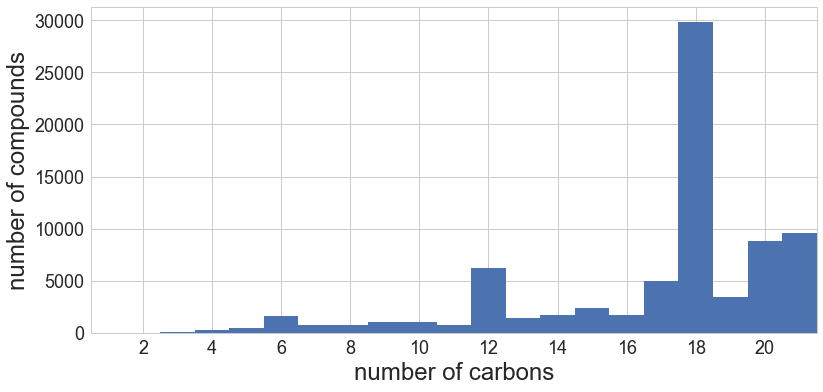

In [84]:
sns.set_style("whitegrid")
plt.figure(figsize = (13,6))
numC = df_mols.numC.values
sns.distplot(numC, np.arange(0, 23), kde = False, hist_kws={'alpha':1})
labels = [str(i) for i in np.arange(0, 22, 2)]
xt = plt.xticks(np.arange(0.5, 22,2), labels, fontsize = 18)
yt = plt.yticks(fontsize = 18)
plt.xlim(1, 22)
yl = plt.ylabel('number of compounds', fontsize = 24)
xl = plt.xlabel('number of carbons', fontsize = 24)


path_temp = '/Users/ajinich/Dropbox (Aspuru-Guzik Lab)/Quantum/redox/data_for_Ben/figures'
plt.savefig(os.path.join(path_temp, 'numC_distro.png'), dpi = 200)


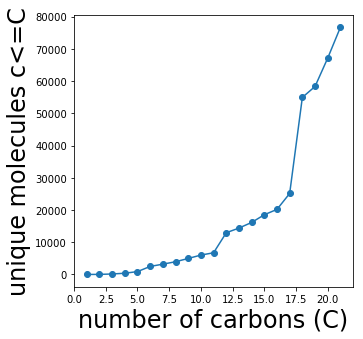

In [23]:
plt.figure(figsize = (5,5))
plt.plot(nC_arr, mols_nC_list.values(), '-o')
plt.xlabel('number of carbons (C)', fontsize=24)
plt.ylabel('unique molecules c<=C', fontsize = 24)

Is this due to numbers in KEGG? Apparently not!

In [238]:
nC_arr = np.arange(1, df_mols.numC.max()+1)
KEGG_nC_list = {}
for nC in nC_arr:
    KEGG_nC = df_kegg[df_kegg.numC<=nC].shape[0]
    KEGG_nC_list[nC] = KEGG_nC

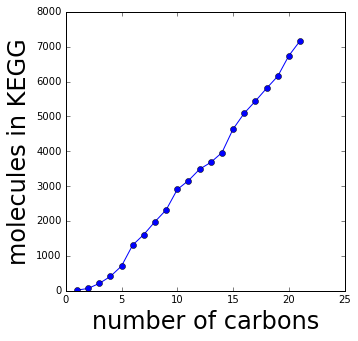

In [239]:
plt.figure(figsize = (5,5))
plt.plot(nC_arr, KEGG_nC_list.values(), '-o')
plt.xlabel('number of carbons', fontsize=24)
plt.ylabel('molecules in KEGG', fontsize = 24)

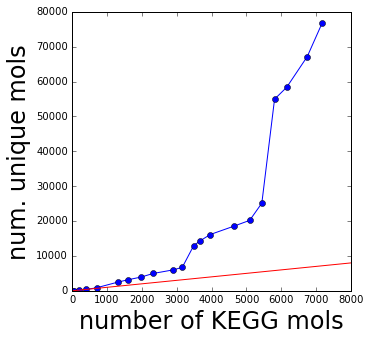

In [245]:
plt.figure(figsize = (5,5))
plt.plot(KEGG_nC_list.values(), mols_nC_list.values(), '-o')
plt.plot((0, 8000), (0,8000), 'r-')
plt.xlabel('number of KEGG mols', fontsize=24)
plt.ylabel('num. unique mols', fontsize = 24)

What's going on? at 18 carbons, there must be some molecules with a many (=O) or (-OH) or (-NH) groups

reactions: 

In [293]:
def get_num_C_rxn(row, df_mols):
    sub = row.rxn_ID.split(' = ')[0]
    return df_mols[df_mols.BA_ID == sub].numC

In [ ]:
df_redox['numC'] = df_redox.apply(get_num_C_rxn, 1, args = [df_mols])

In [ ]:
df_redox.head(5)

# Appendix: fixing bugs in G3 oxidations: 

These are the G3 reduction strings; 

In [ ]:
#aldehydes
G3_ald = AllChem.ReactionFromSmarts('[CX3H1:2](=O)[#6:1]>>[#6:1][CX4H2:2][NX3;H2,H1;!$(NC=O)]')
G3_ald_new = AllChem.ReactionFromSmarts('[#6:1][CX3H1:2](=O)>>[#6:1][NX3;H2;!$(NC=[!#6]);!$(NC#[!#6])]')

#Ketones
G3_ket = AllChem.ReactionFromSmarts('[#6:1][CX3:2](=O)[#6:3]>>[C:1][CX4H1:2]([C:3])[NX3;H2,H1;!$(NC=O)]')


These are the G3 oxidation strings: 

In [ ]:
#aldehydes
#G3_ald_ox = AllChem.ReactionFromSmarts('[#6:1][CX4H2:2][NX3;H2,H1;!$(NC=O)]>>[CX3H1:2](=O)[#6:1]')
G3_ald_ox = AllChem.ReactionFromSmarts('[#6:1][CX4H2:2][NX3;H2;!$(NC=[!#6]);!$(NC#[!#6])]>>[#6:1][CX3H1:2](=O)')
G3_ald_ox_rev = AllChem.ReactionFromSmarts('[#6:1][CX4H2:2][NX3;H2;!$(NC=[!#6]);!$(NC#[!#6])]>>[#6:1][CX3H1:2](=O)')

#Ketones
G3_ket_ox = AllChem.ReactionFromSmarts('[C:1][CX4H1:2]([C:3])[NX3;H2;!$(NC=[!#6]);!$(NC#[!#6])]>>[#6:1][CX3H0:2](=O)[#6:3]')
#G3_ket_ox = AllChem.ReactionFromSmarts('[C:1][CX4H1:2]([C:3])[NX3;H2,H1;!$(NC=O)]>>[#6:1][CX3H0:2](=O)[#6:3]')


In [ ]:
def G3_function_ox(metab_smiles):
    reactant = Chem.MolFromSmiles(metab_smiles)
    prod_list = []
    
    #Aldehyde oxidation
    prod_1 = G3_ald_ox.RunReactants([reactant])
    if len(prod_1) > 0:
        for x in prod_1:
            smiles = Chem.MolToSmiles(x[0])
            prod_list.append(smiles)
    #Ketone oxidation        
    prod_2 = G3_ket_ox.RunReactants([reactant])
    if len(prod_2) > 0:
        for x in prod_2:
            smiles = Chem.MolToSmiles(x[0])
            prod_list.append(smiles)
    return prod_list

In [ ]:
smiles_test = u'CC1CN1'
print 'this is the test substrate:'
display(AllChem.MolFromSmiles(smiles_test))
reactant = Chem.MolFromSmiles(smiles_test)
prod_1 = G3_ald_ox.RunReactants([reactant])
print 'these are the products:'
for x in prod_1:
    smiles = Chem.MolToSmiles(x[0])
    display(AllChem.MolFromSmiles(smiles))


In [ ]:
smiles_test = u'CCNCC=O'
print 'this is the test substrate:'
display(AllChem.MolFromSmiles(smiles_test))
reactant = Chem.MolFromSmiles(smiles_test)
prod_1 = G3_ket_ox.RunReactants([reactant])
for x in prod_1:
    smiles = Chem.MolToSmiles(x[0])
    display(AllChem.MolFromSmiles(smiles))


_____________________________
_____________________________
_____________________________
_____________________________
_____________________________
_____________________________
_____________________________
_____________________________
_____________________________

# Appendix 1: early attemps at n-carbon network: 

### First run function on 2-carbon redox network: 

In [ ]:
two_C_list =  ['OC(=O)C(O)=O']

In [ ]:
# Empty list of all reactions. 
rxn_list = []
Master_Sub_List = []
counter = 0
for metabolite in two_C_list:
    # Run reduction function on a single metabolite
    rxn_list_temp, Master_Sub_List = reduce_metabolite(metabolite, Master_Sub_List)
    # print 'Current rxn_list_temp', rxn_list_temp
    
    # If there are some reactions, store in reaction list
    if len(rxn_list_temp) > 0:
        rxn_list += rxn_list_temp
        # Make Unique (necessary ?)
        rxn_list = list(set(rxn_list)) 
    # Update Master_Sub_List
    new_subs_list = [rxn.split('>>')[0] for rxn in rxn_list_temp]
    Master_Sub_List += new_subs_list
    Master_Sub_List = list(set(Master_Sub_List))
    

I want to get rid of G3s for now:

In [ ]:
rxn_list_noG3 = [rxn for rxn in rxn_list if not "N" in rxn]

Get unique metabolites: 

In [ ]:
all_mols = list(set([rxn.split('>>')[0] for rxn in rxn_list_noG3] + [rxn.split('>>')[1] for rxn in rxn_list_noG3]))

In [ ]:
file_2C_mols = 'rxn_networks/mols_2C.txt'
file_2C_rxns = 'rxn_networks/rxns_2C.txt'
with open(file_2C_mols,'wb') as fm:
    for mol in all_mols:
        fm.write(mol+'\n')
with open(file_2C_rxns, 'wb') as fr:
    for rxn in rxn_list_noG3:
        fr.write(rxn+'\n')

# Appendix 2: Ignore this for now

In [ ]:
df = pd.read_csv("~/Dropbox/Quantum/redox/data_for_Ben/All_Redox_Reactions.csv")

In [ ]:
sub_df = df[100:200]
sub_df.head()

In [ ]:
sub_df['Category'] = sub_df.apply(categorize_rxn, 1)

In [ ]:
sub_df

In [ ]:
rxn_list = list(df['Reaction'].values)

In [ ]:
rxn = rxn_list[100000]
print rxn

In [ ]:
display(AllChem.ReactionFromSmarts(rxn))

In [ ]:
for rxn in rxn_list[:200]:
    print rxn
    display(AllChem.ReactionFromSmarts(rxn))

In [ ]:
display(AllChem.ReactionFromSmarts('OC1CCCCO1>>OCCCCCO'))